In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from patchify import patchify, unpatchify

# Data loading

In [9]:
patch_size=256
from custom_functions import predict_patches

In [10]:
# Create flow_from_directory for training images
def loading_data(dataset_type,category, patch_size):
    # Set your directories
    images_dir = f"Dataset_patched/{dataset_type}_images"
    masks_dir = f"Dataset_patched/{dataset_type}_masks"

    if (dataset_type=='train'):        
        # Create ImageDataGenerator for images
        image_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
        # Create ImageDataGenerator for masks
        mask_datagen = ImageDataGenerator(validation_split=0.2)
        # Create flow_from_directory for training images
        train_image_generator = image_datagen.flow_from_directory(
            images_dir,
            target_size=(patch_size,patch_size),  # Set the target size for your images
            batch_size=16,  # Set the batch size
            class_mode=None,  # Since this is only for images, class_mode should be None
            shuffle=True,  # Shuffle the data
            seed=42,
            color_mode='grayscale',
            subset='training'
            )
        # Create flow_from_directory for training masks
        train_mask_generator = mask_datagen.flow_from_directory(
            masks_dir,
            target_size=(patch_size,patch_size),  # Set the target size for your masks
            batch_size=16,  # Set the batch size
            class_mode=None,
            classes=[category],  # Since this is only for masks, class_mode should be None
            shuffle=True,  # Shuffle the data
            seed=42,
            color_mode='grayscale',
            subset='training'
        )
        # Combine generators into one which yields training image and masks
        train_generator = zip(train_image_generator, train_mask_generator)

        # Create flow_from_directory for validation images
        val_image_generator = image_datagen.flow_from_directory(
            images_dir,
            target_size=(patch_size,patch_size),  # Set the target size for your images
            batch_size=16,  # Set the batch size
            class_mode=None,  # Since this is only for images, class_mode should be None
            shuffle=False,  # Do not shuffle for validation
            seed=42,
            color_mode='grayscale',
            subset='validation'
        )
        # Create flow_from_directory for validation masks
        val_mask_generator = mask_datagen.flow_from_directory(
            masks_dir,
            target_size=(patch_size,patch_size),  # Set the target size for your masks
            batch_size=16,  # Set the batch size
            class_mode=None,
            classes=[category],  # Since this is only for masks, class_mode should be None
            shuffle=False,  # Do not shuffle for validation
            seed=42,
            color_mode='grayscale',
            subset='validation'
        )
        # Combine generators into one which yields validation image and masks
        val_generator = zip(val_image_generator, val_mask_generator)
        return train_generator, train_image_generator, val_generator, val_image_generator
    
    elif(dataset_type=='test'): 
        image_datagen = ImageDataGenerator(rescale=1./255)
        # Create ImageDataGenerator for masks
        mask_datagen = ImageDataGenerator()

        test_image_generator = image_datagen.flow_from_directory(
            images_dir,
            target_size=(patch_size,patch_size),  # Set the target size for your images
            batch_size=24,  # Set the batch size
            class_mode=None,
            shuffle=False,
            seed=42,
            color_mode='grayscale'
            )
        # Create flow_from_directory for training masks
        test_mask_generator = mask_datagen.flow_from_directory(
            masks_dir,
            target_size=(patch_size,patch_size),  # Set the target size for your masks
            batch_size=24,  # Set the batch size
            class_mode=None,
            classes=[category],
            shuffle=False, 
            seed=42,
            color_mode='grayscale'
        )
        # Combine generators into one which yields training image and masks
        test_generator = zip(test_image_generator, test_mask_generator)
        return test_image_generator, test_mask_generator
    else:
        print("Invalid data type. Provide valid data type: train or test.")


# Functions for model training & evaluation


In [36]:
# Early Stopping
from keras.callbacks import EarlyStopping
monitor_val_iou = EarlyStopping(monitor='val_iou',
                   patience=5,
                   restore_best_weights='True',
                   mode='max')
# Custom Metrics
from custom_metrics import f1,iou

In [12]:
# U-Net model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1, iou])
    model.summary()
    
    return model

In [13]:
# Model training
def model_training(category, patch_size, epochs):
    
    train_generator, train_image_generator, val_generator, val_image_generator = loading_data('train',category,patch_size)
    model = simple_unet_model(patch_size, patch_size, 1)
    hist=model.fit(train_generator,steps_per_epoch=len(train_image_generator), epochs = epochs, callbacks = monitor_val_iou,validation_steps = val_image_generator.samples//16, validation_data = val_generator)  
    
    #Learning curves 
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    
    loss= hist.history['loss']
    val_loss=hist.history['val_loss']
    epochs = range(1, len(loss) + 1)
    axs[0].plot(epochs,loss, label='loss')
    axs[0].plot(epochs,val_loss, label='val_loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch') 
    axs[0].set_title('Model Loss')
    axs[0].legend(loc='upper right')

    iou= hist.history['iou']
    val_iou=hist.history['val_iou']
    epochs = range(1, len(iou) + 1)
    axs[1].plot(epochs,iou, label='IoU')
    axs[1].plot(epochs,val_iou, label='IoU')
    axs[1].set_ylabel('IoU')
    axs[1].set_xlabel('Epoch')
    axs[1].set_title('Model IoU')
    axs[1].legend(loc='upper right')

    return model

In [14]:
# Image examples and IoU score
def performance(category, model, patch_size, images_list):
    test_image_generator, test_mask_generator=loading_data('test',category,patch_size)
    # Get all predictions for the entire test dataset
    all_predictions = model.predict(test_image_generator, steps=len(test_image_generator), verbose=0)

    # Initialize arrays to store true masks
    all_true_masks = []

    # Loop through the entire test dataset and accumulate true masks
    for _ in range(len(test_mask_generator)):
        true_masks = next(test_mask_generator)
        all_true_masks.append(true_masks)

    # Concatenate the arrays to get the masks for the entire dataset
    all_true_masks = np.concatenate(all_true_masks, axis=0)

    # Apply threshold to convert predicted masks to binary masks (if needed)
    threshold = 0.5
    all_predicted_binary = all_predictions > threshold

    # Calculate IoU for the entire dataset
    iou_performance = iou(all_true_masks, all_predicted_binary)
    print("IoU for the entire test dataset:", iou_performance.numpy())
    
    for path in images_list:
        image, preds = predict_patches(path, model, patch_size)
        predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
        # Plot predictions
        fig, axs = plt.subplots(1, 2, figsize=(25, 25))
        # Original image
        axs[0].imshow(image)
        # Predicted mask
        axs[1].imshow(predicted_mask > 0.5)
        

# Models

## 1. Root Model

### 1.1 Model training 

Found 7648 images belonging to 1 classes.
Found 7648 images belonging to 1 classes.
Found 1911 images belonging to 1 classes.
Found 1911 images belonging to 1 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)       

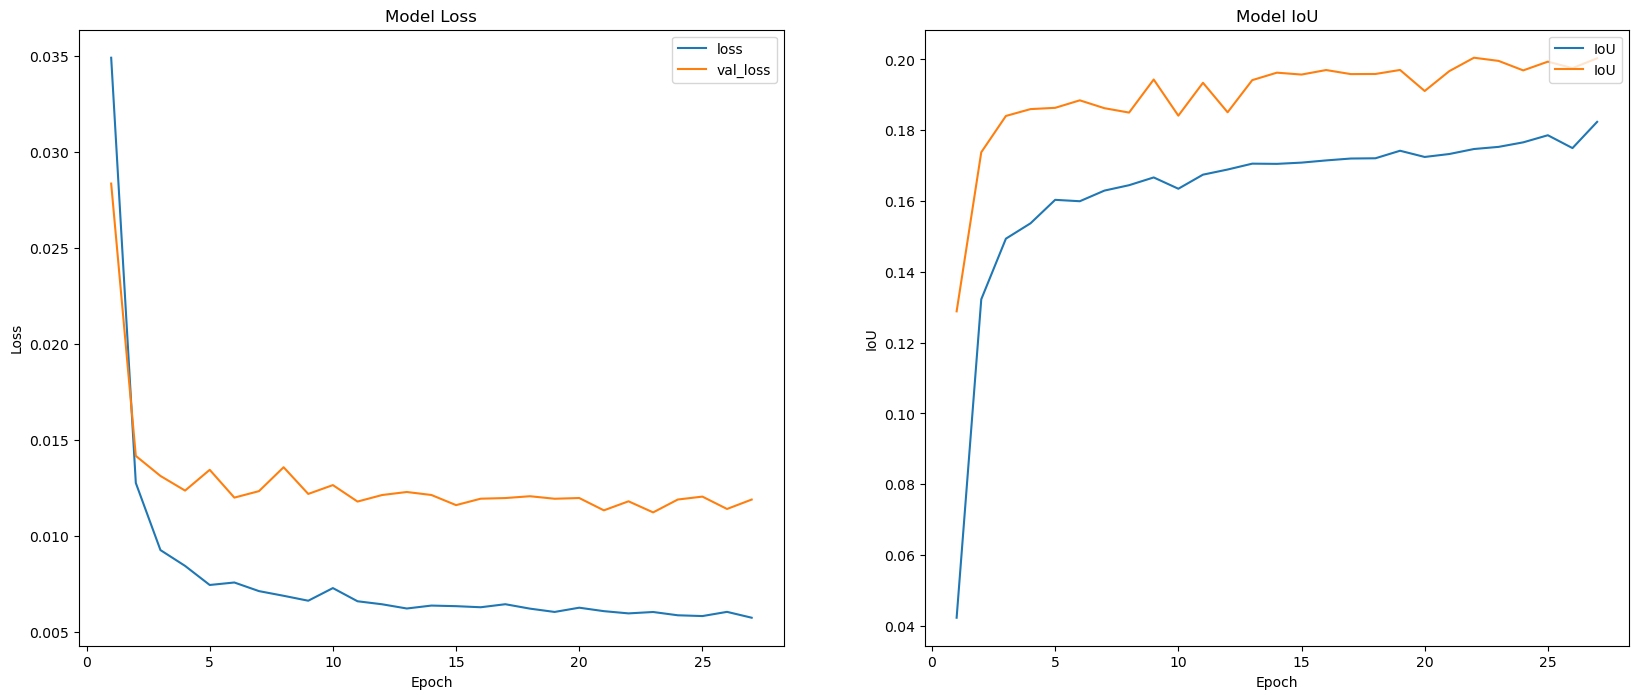

In [15]:
root_model=model_training('root',patch_size,30)

### 1.2 Performance


In [28]:
test_images_list= ['Dataset/test/035_43-17-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_04-Fish Eye Corrected.png', 'Dataset/test/034_43-14-ROOT1-2023-08-08_pvdCherry_OD001_Col0_02-Fish Eye Corrected.png', 'Dataset/test/033_43-13-ROOT1-2023-08-08_pvd_OD01_Col0_02-Fish Eye Corrected.png']

Found 2904 images belonging to 1 classes.
Found 2904 images belonging to 1 classes.
IoU for the entire test dataset: 0.9013196


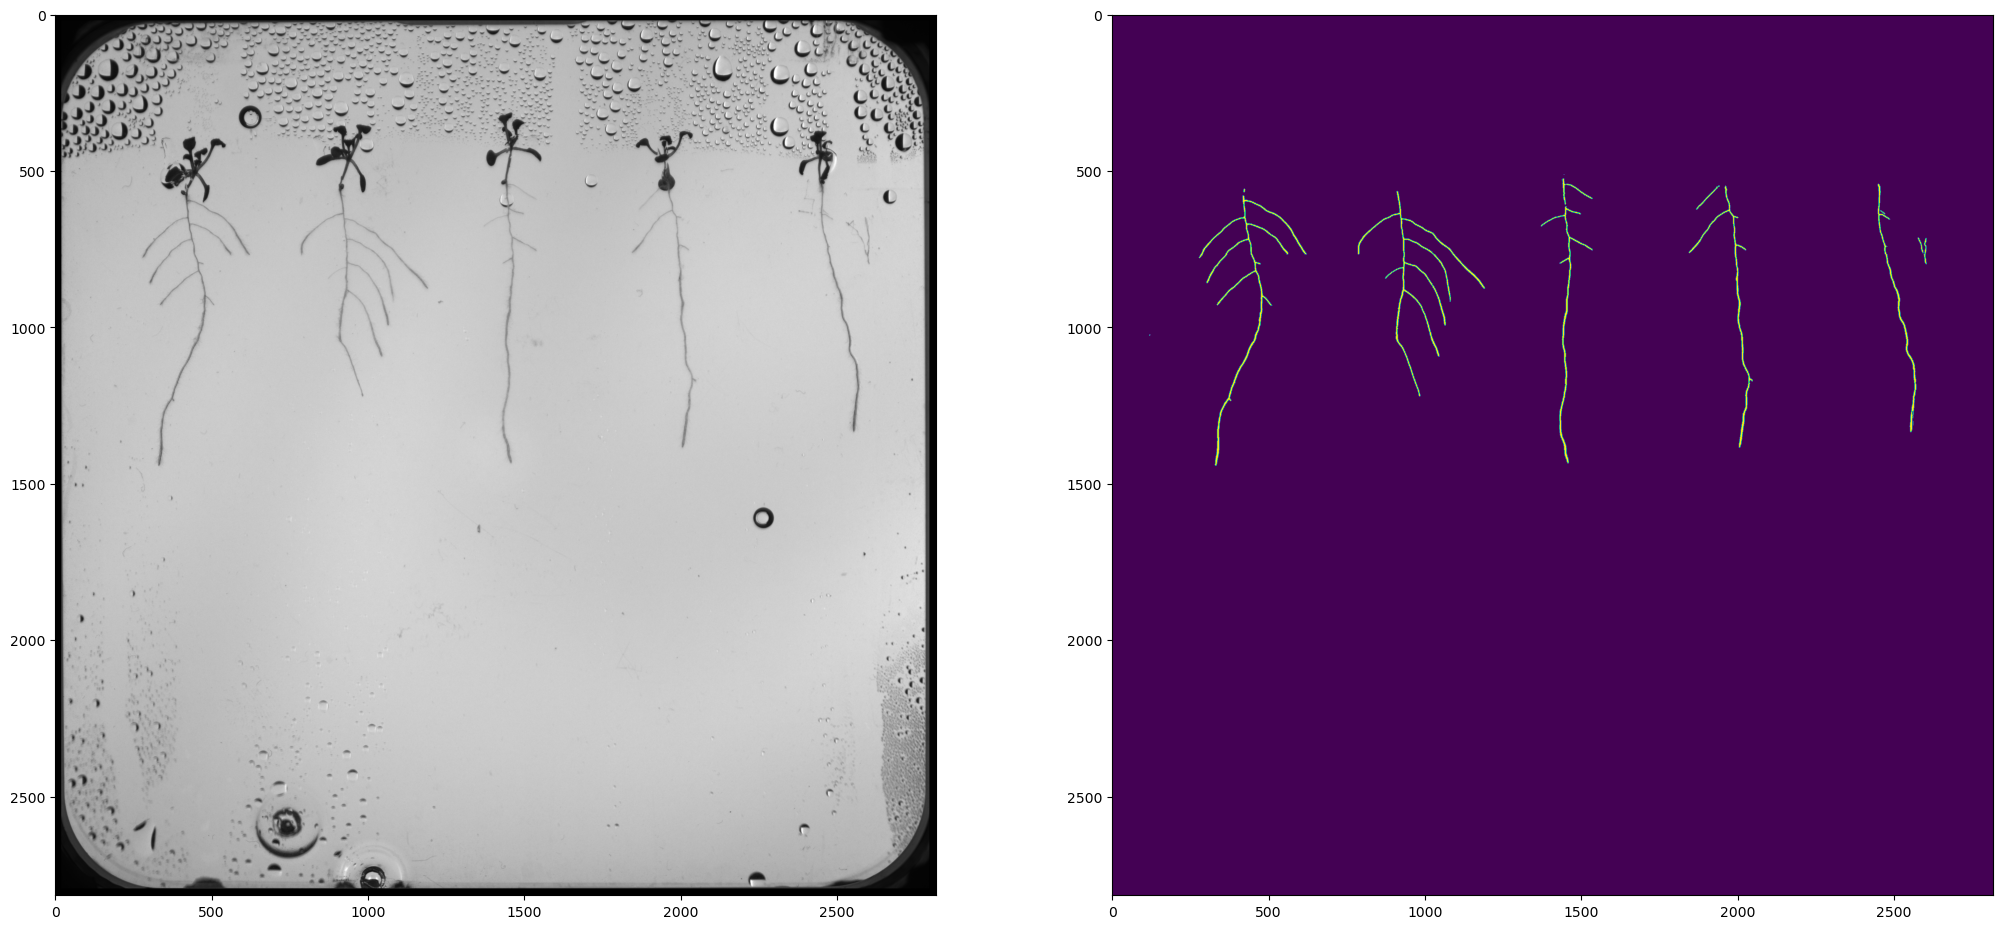

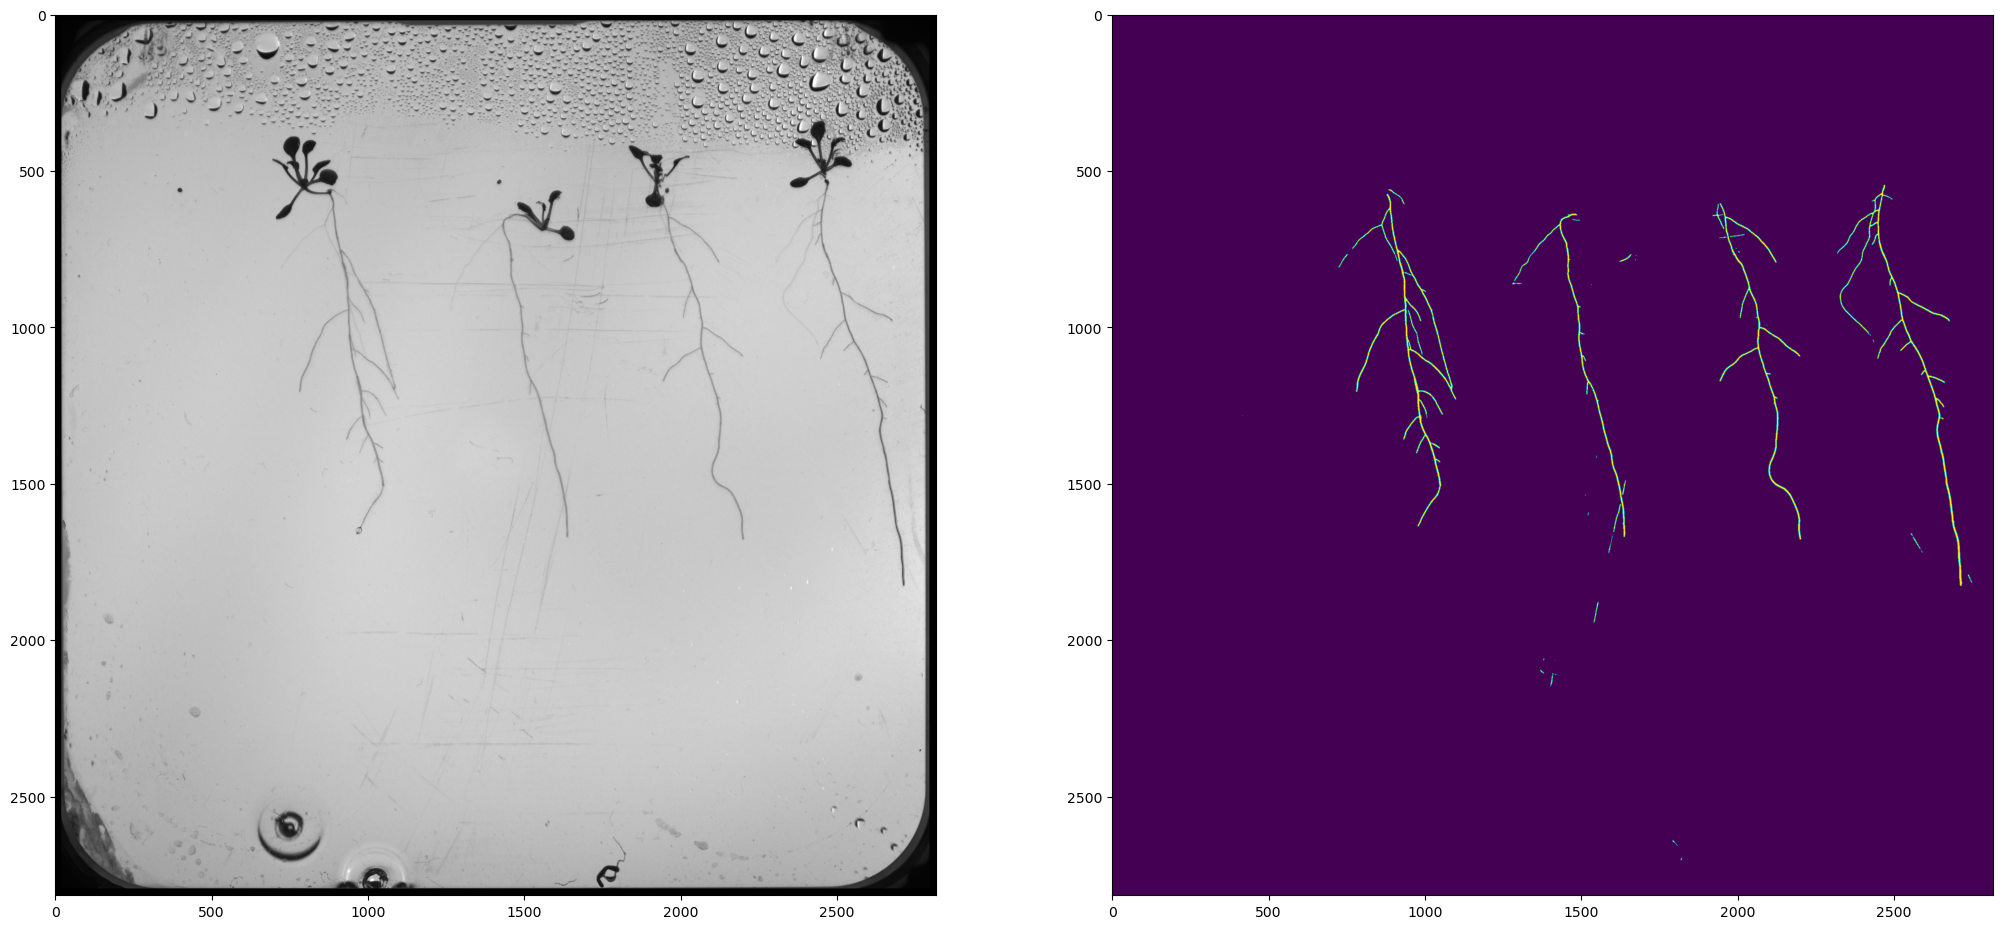

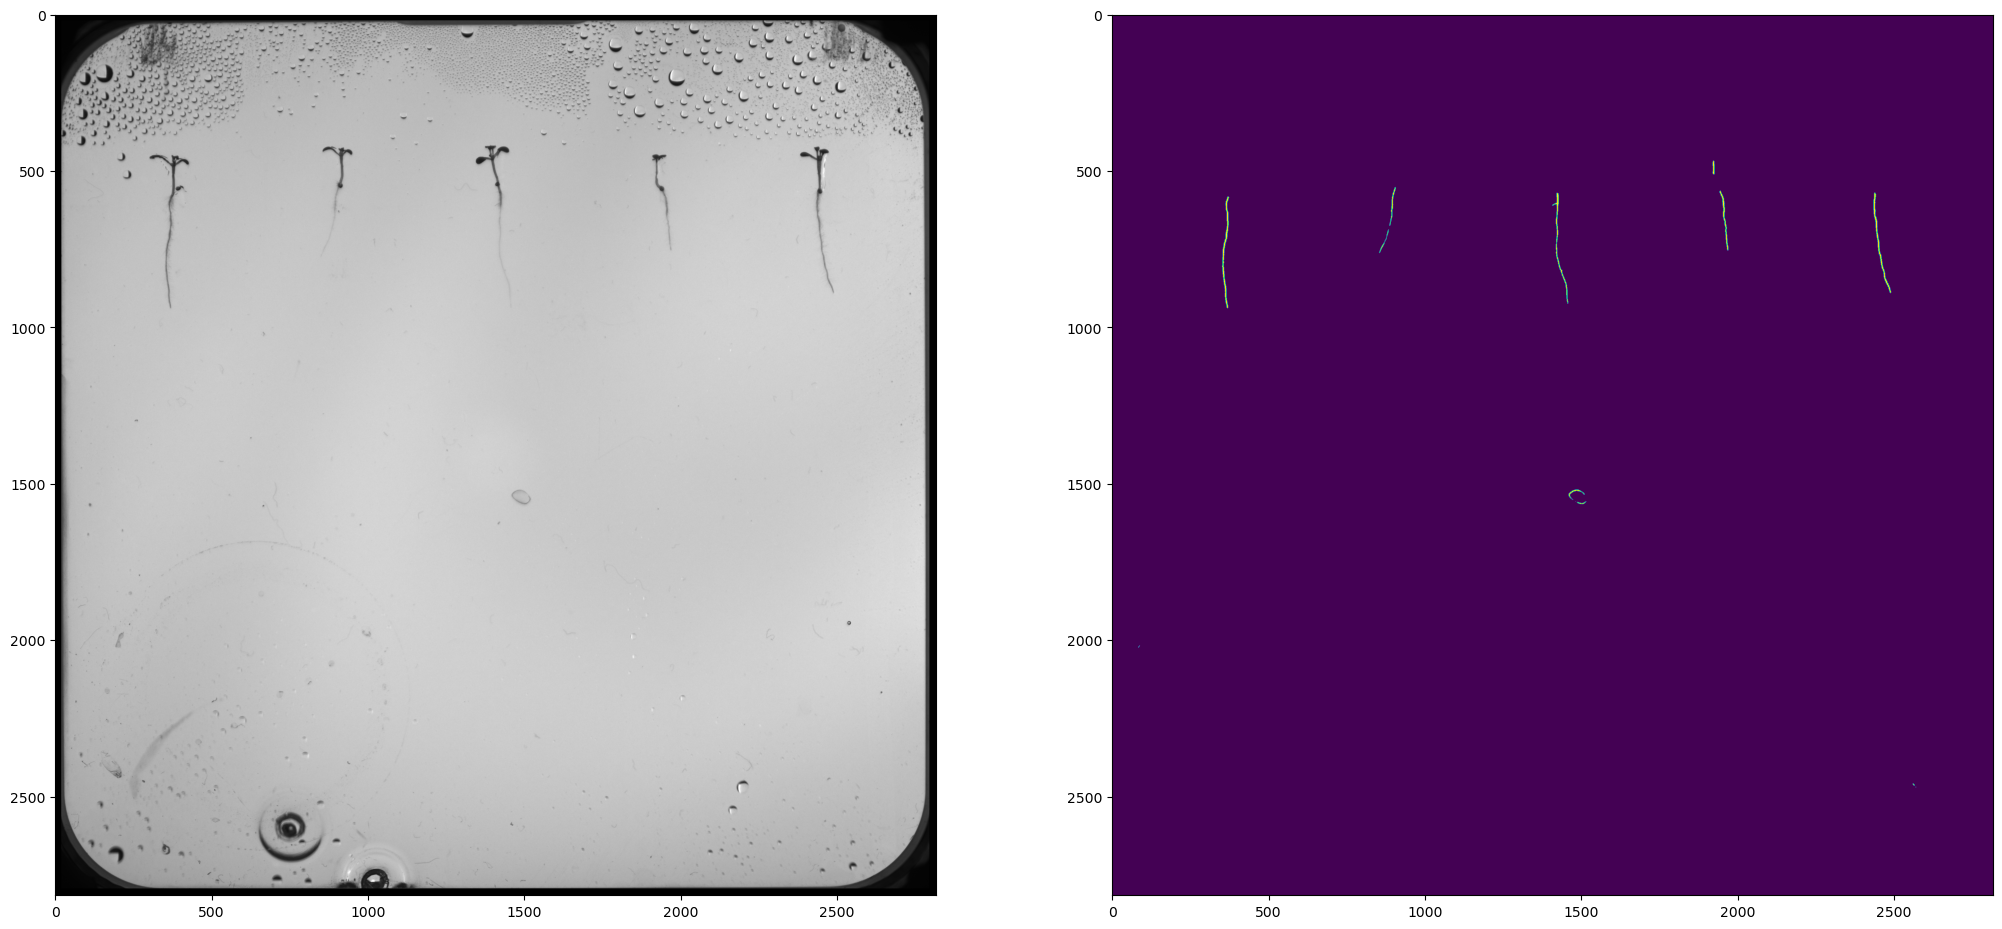

In [37]:
performance('root', root_model, patch_size, images_list=test_images_list)

In [25]:
root_model.save('root_model.h5')

## 2. Shoot Model

### 2.1 Model training 

Found 7648 images belonging to 1 classes.
Found 7648 images belonging to 1 classes.
Found 1911 images belonging to 1 classes.
Found 1911 images belonging to 1 classes.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)   

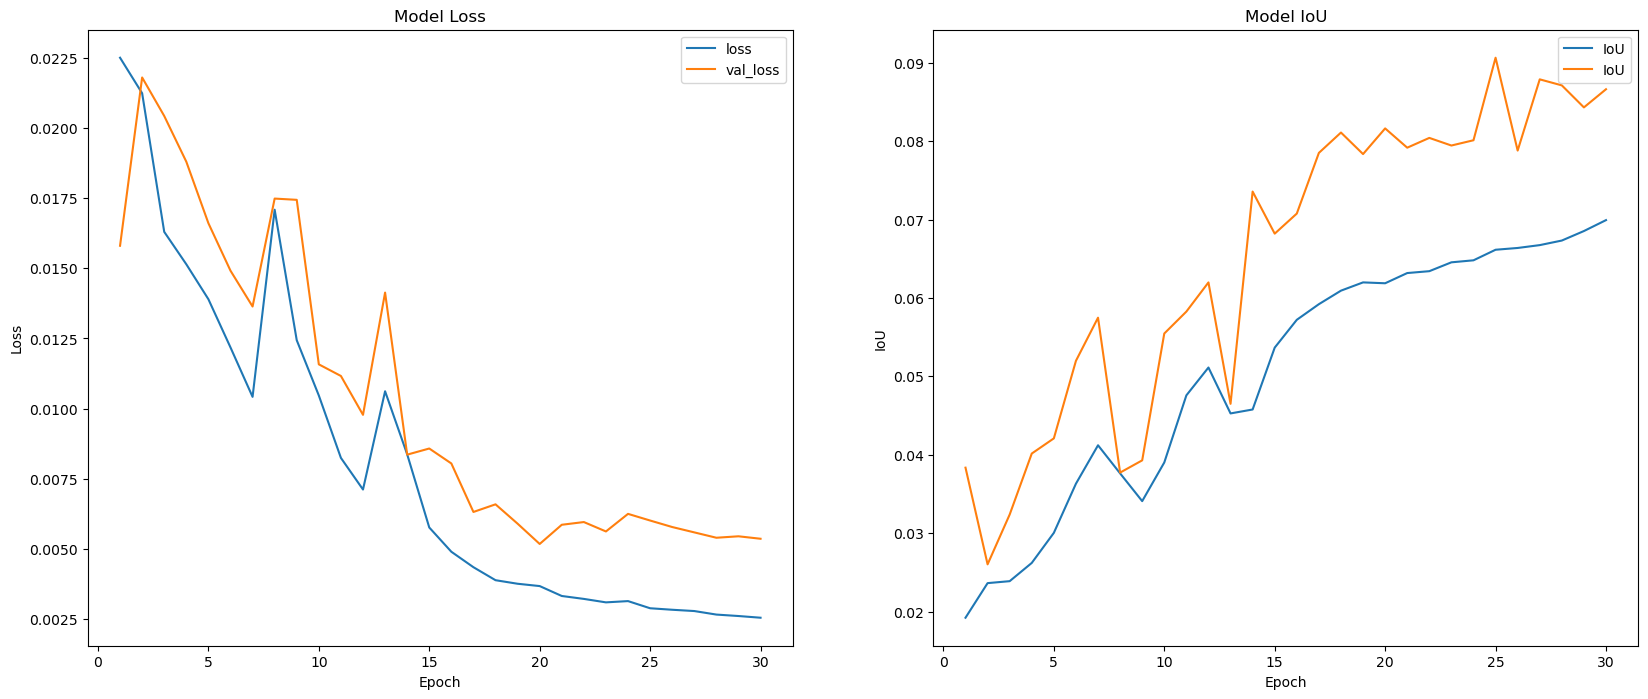

In [18]:
shoot_model=model_training('shoot',patch_size,30)

### 2.2 Performance

Found 2904 images belonging to 1 classes.
Found 2904 images belonging to 1 classes.
IoU for the entire test dataset: 0.93527216


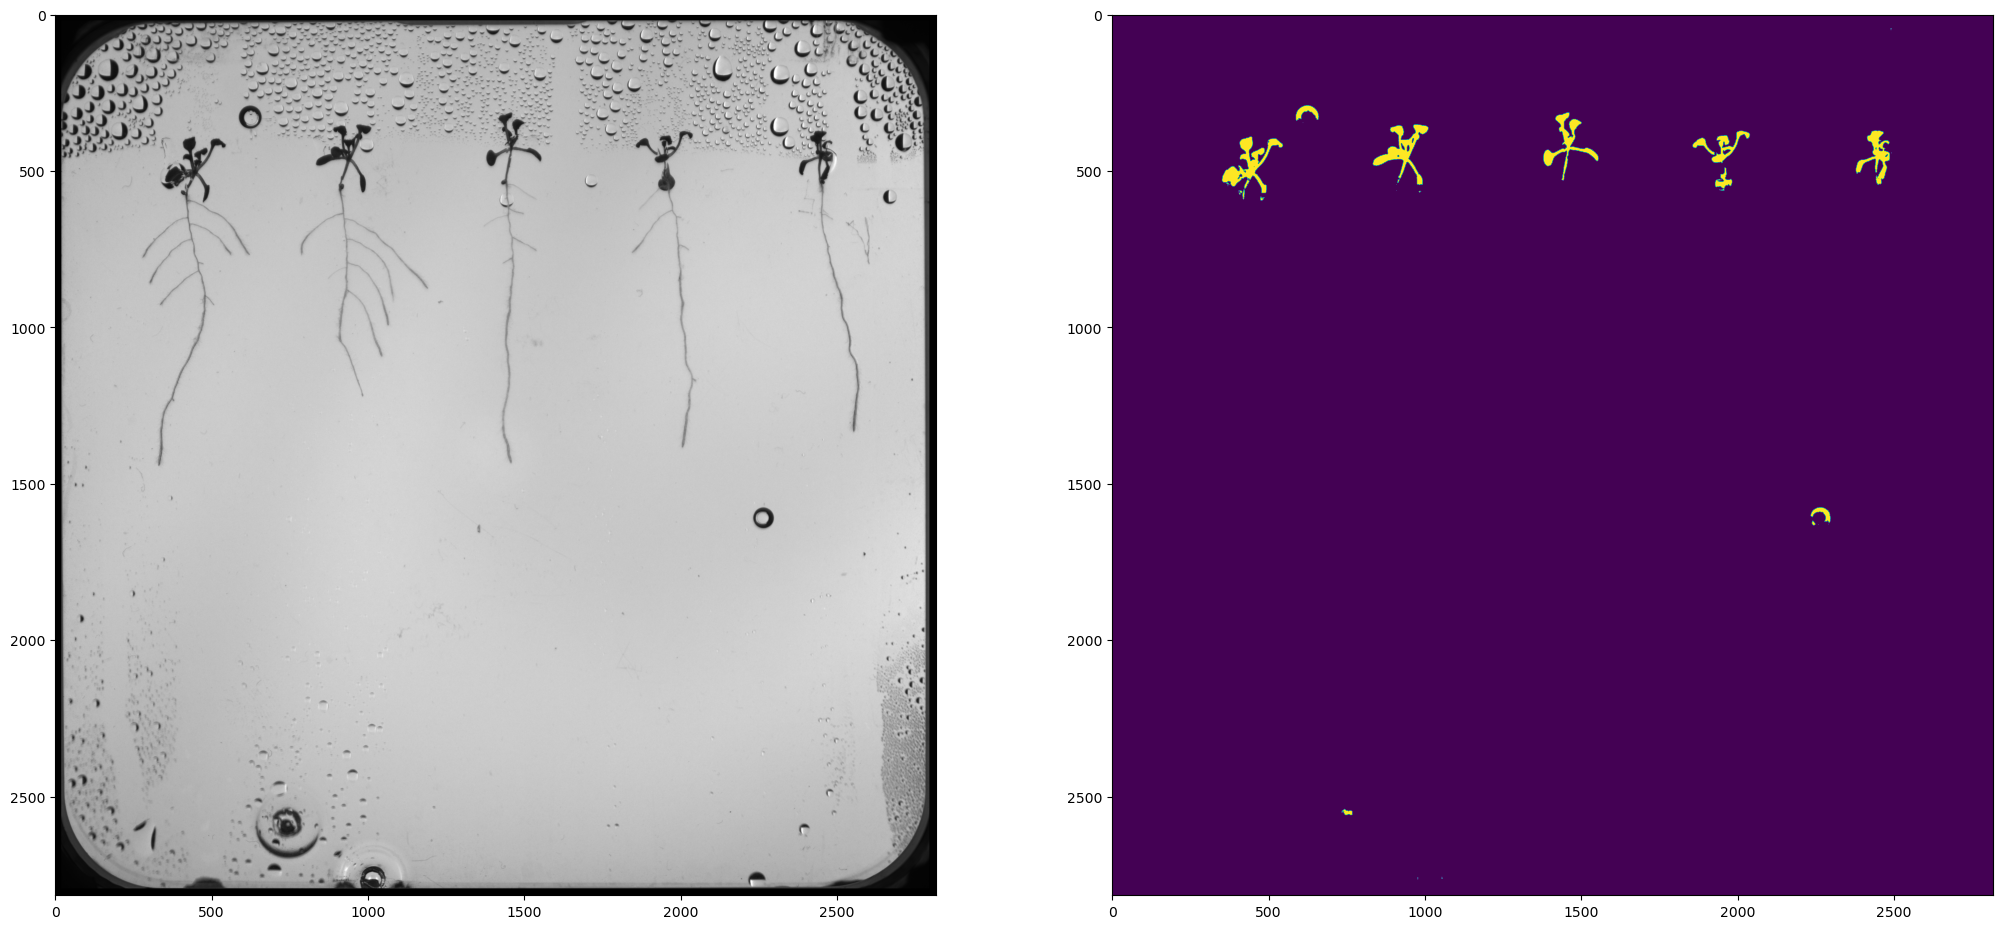

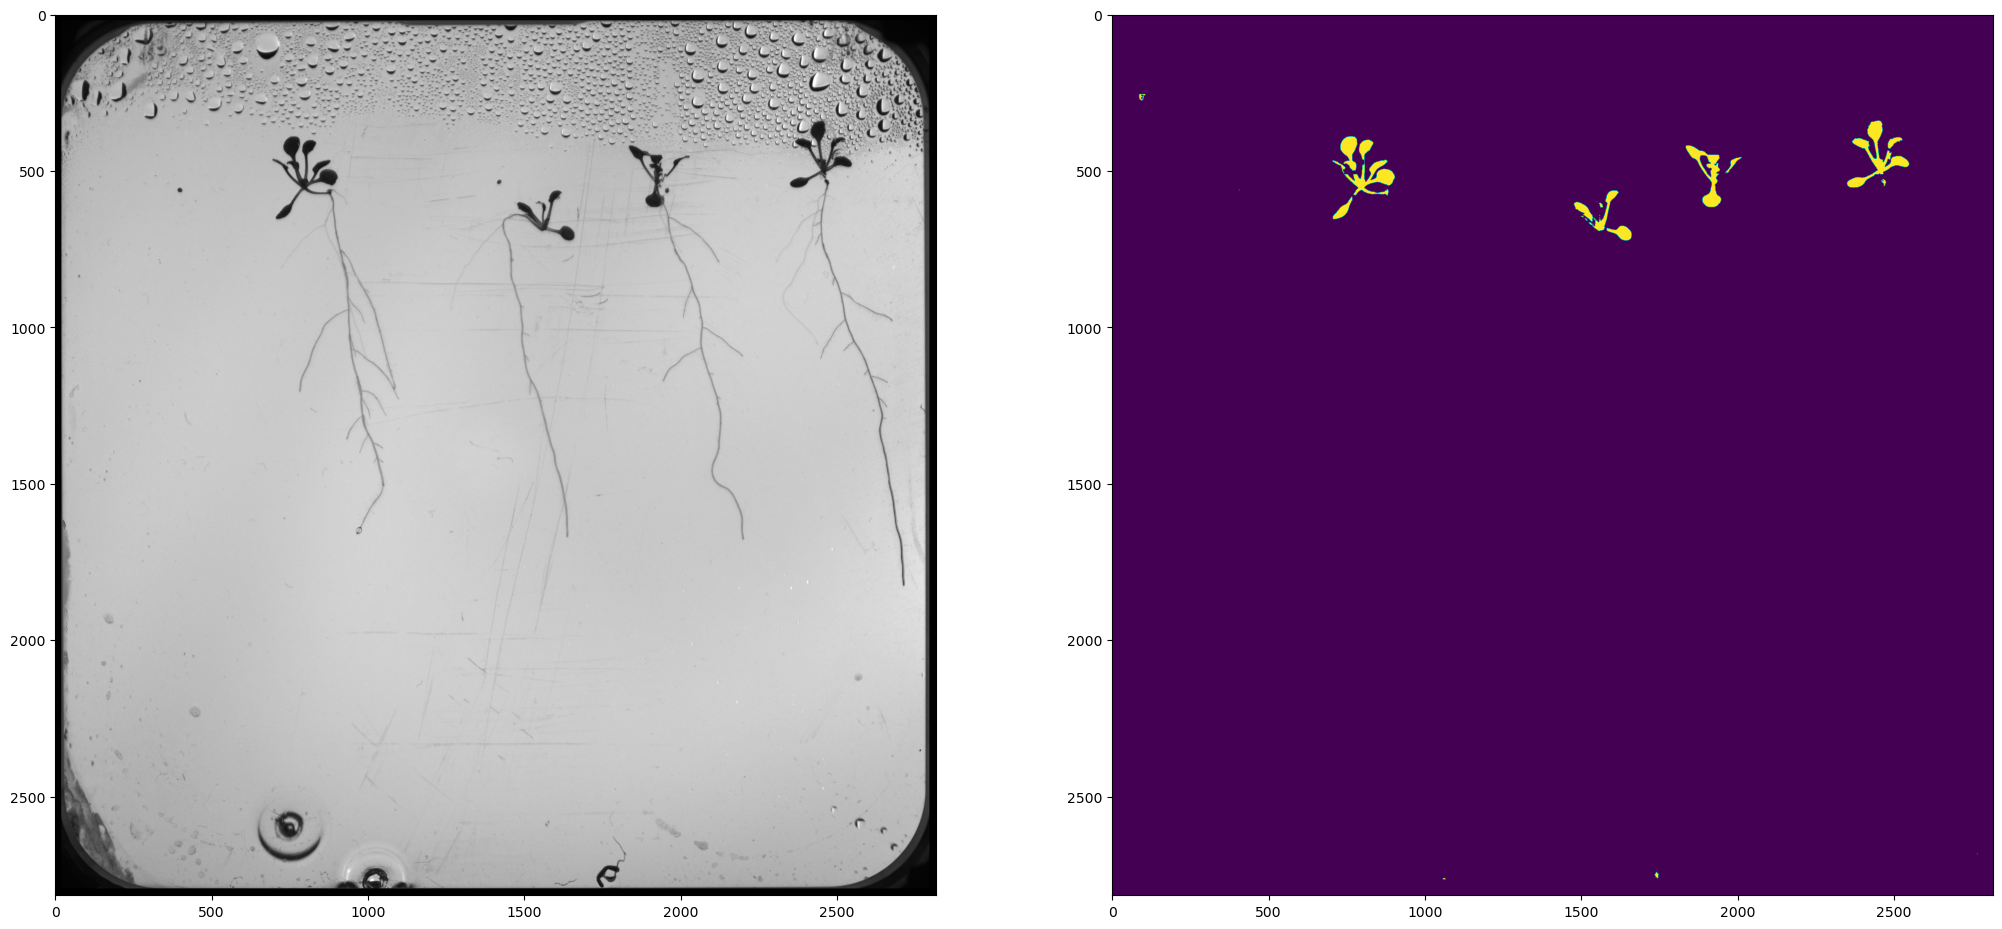

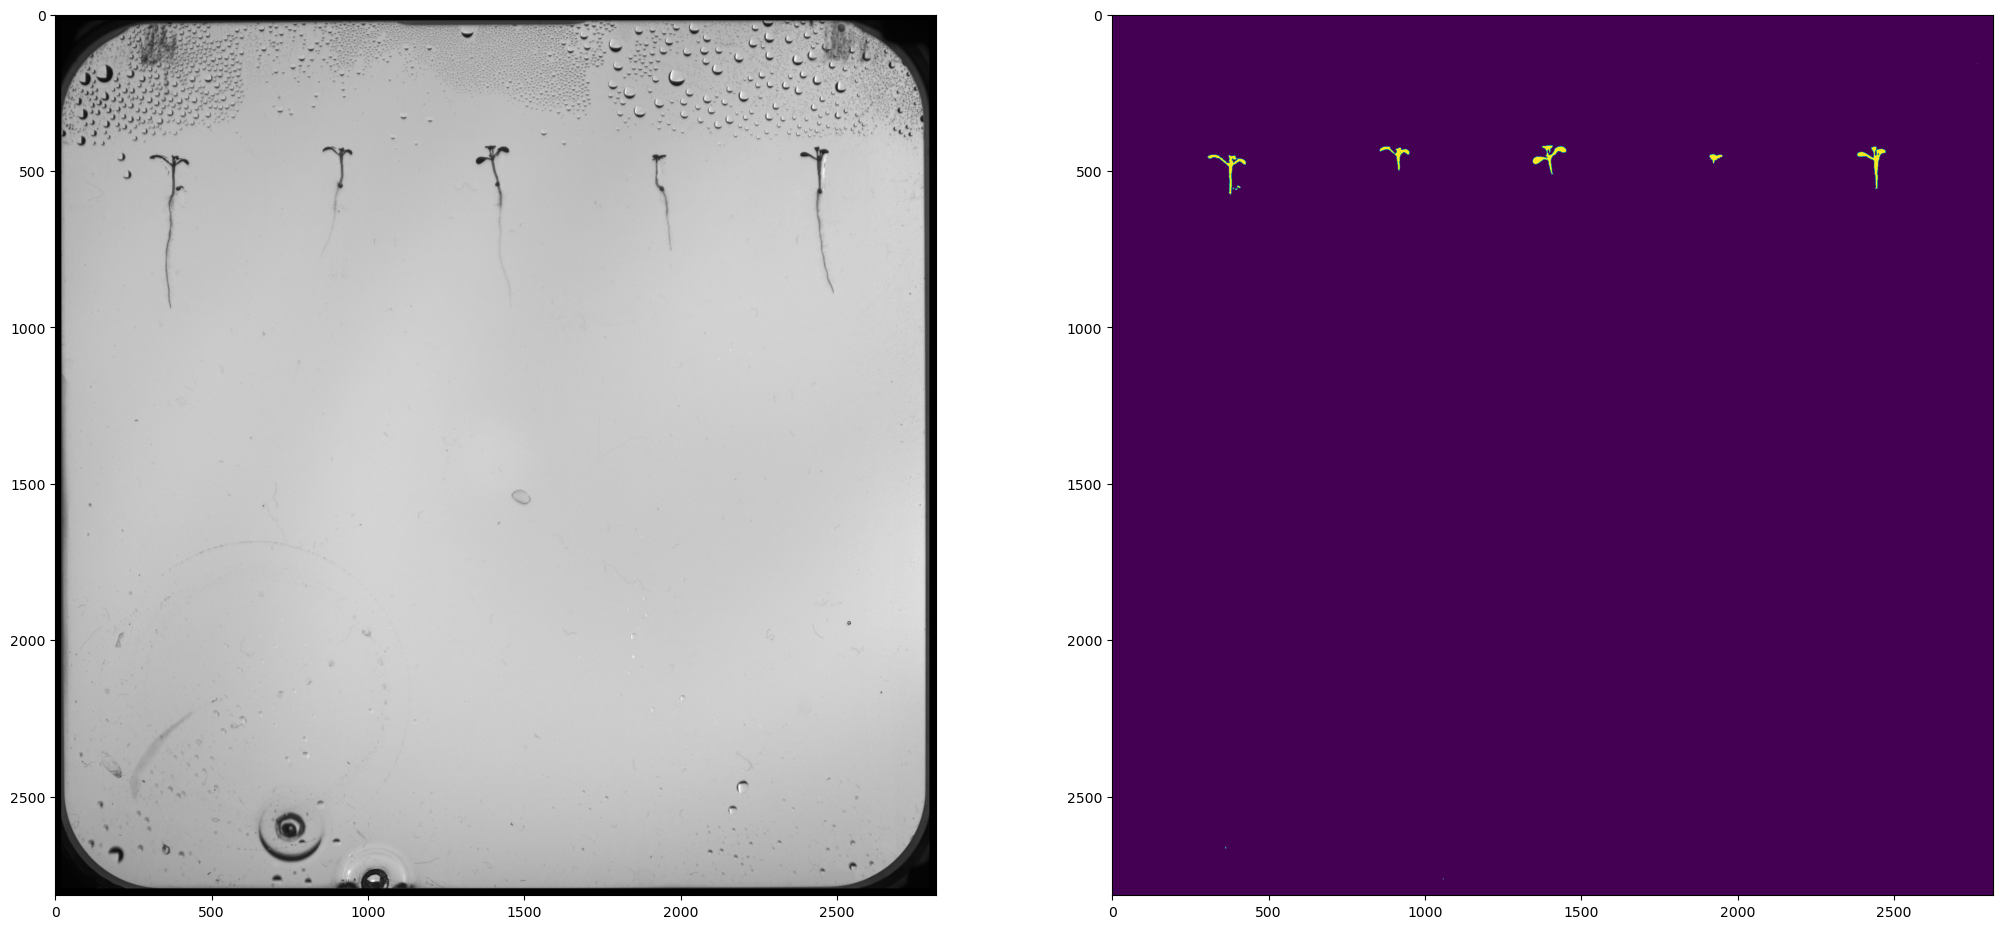

In [38]:
performance('shoot',shoot_model,patch_size,images_list=test_images_list)

## 3. Seed Model

### 3.1 Model training

Found 7648 images belonging to 1 classes.
Found 7648 images belonging to 1 classes.
Found 1911 images belonging to 1 classes.
Found 1911 images belonging to 1 classes.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)  

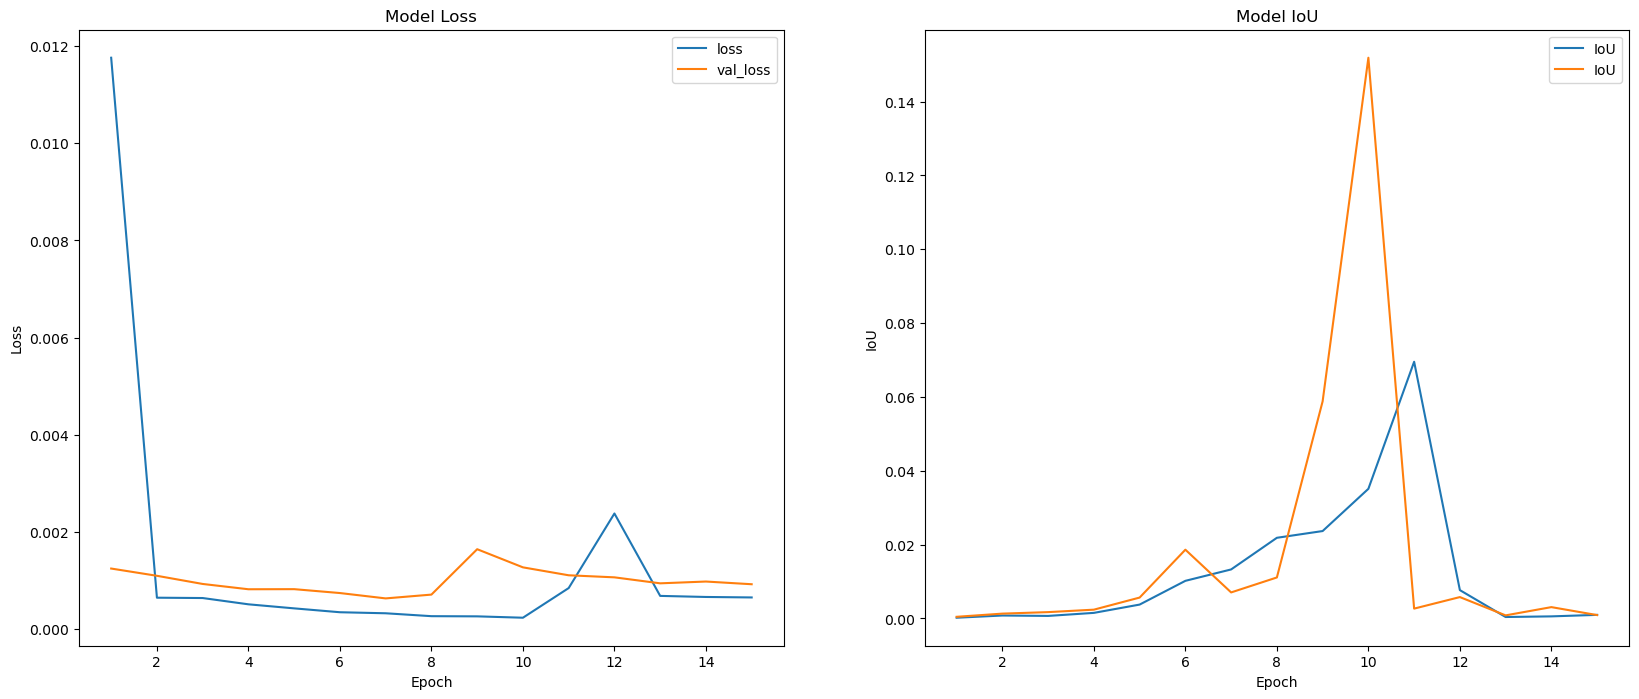

In [20]:
seed_model=model_training('seed',patch_size,30)

### 3.2 Performance

Found 2904 images belonging to 1 classes.
Found 2904 images belonging to 1 classes.
IoU for the entire test dataset: 0.96715367


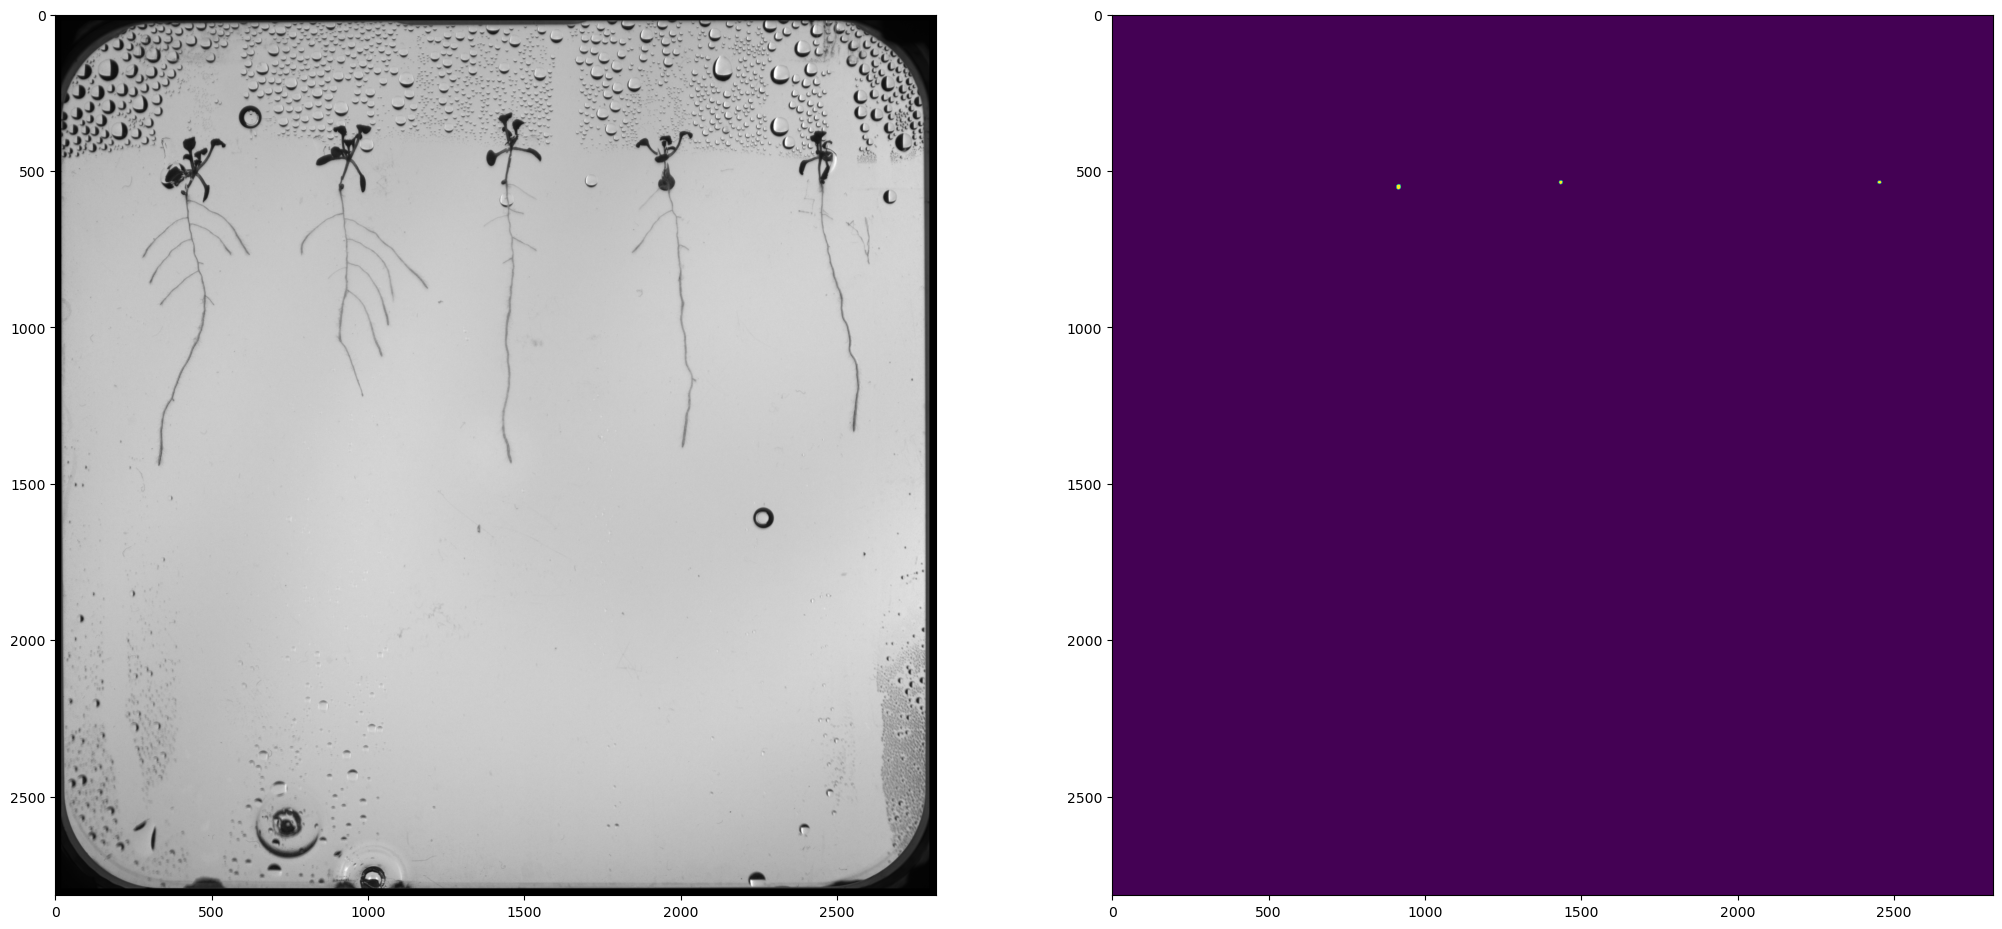

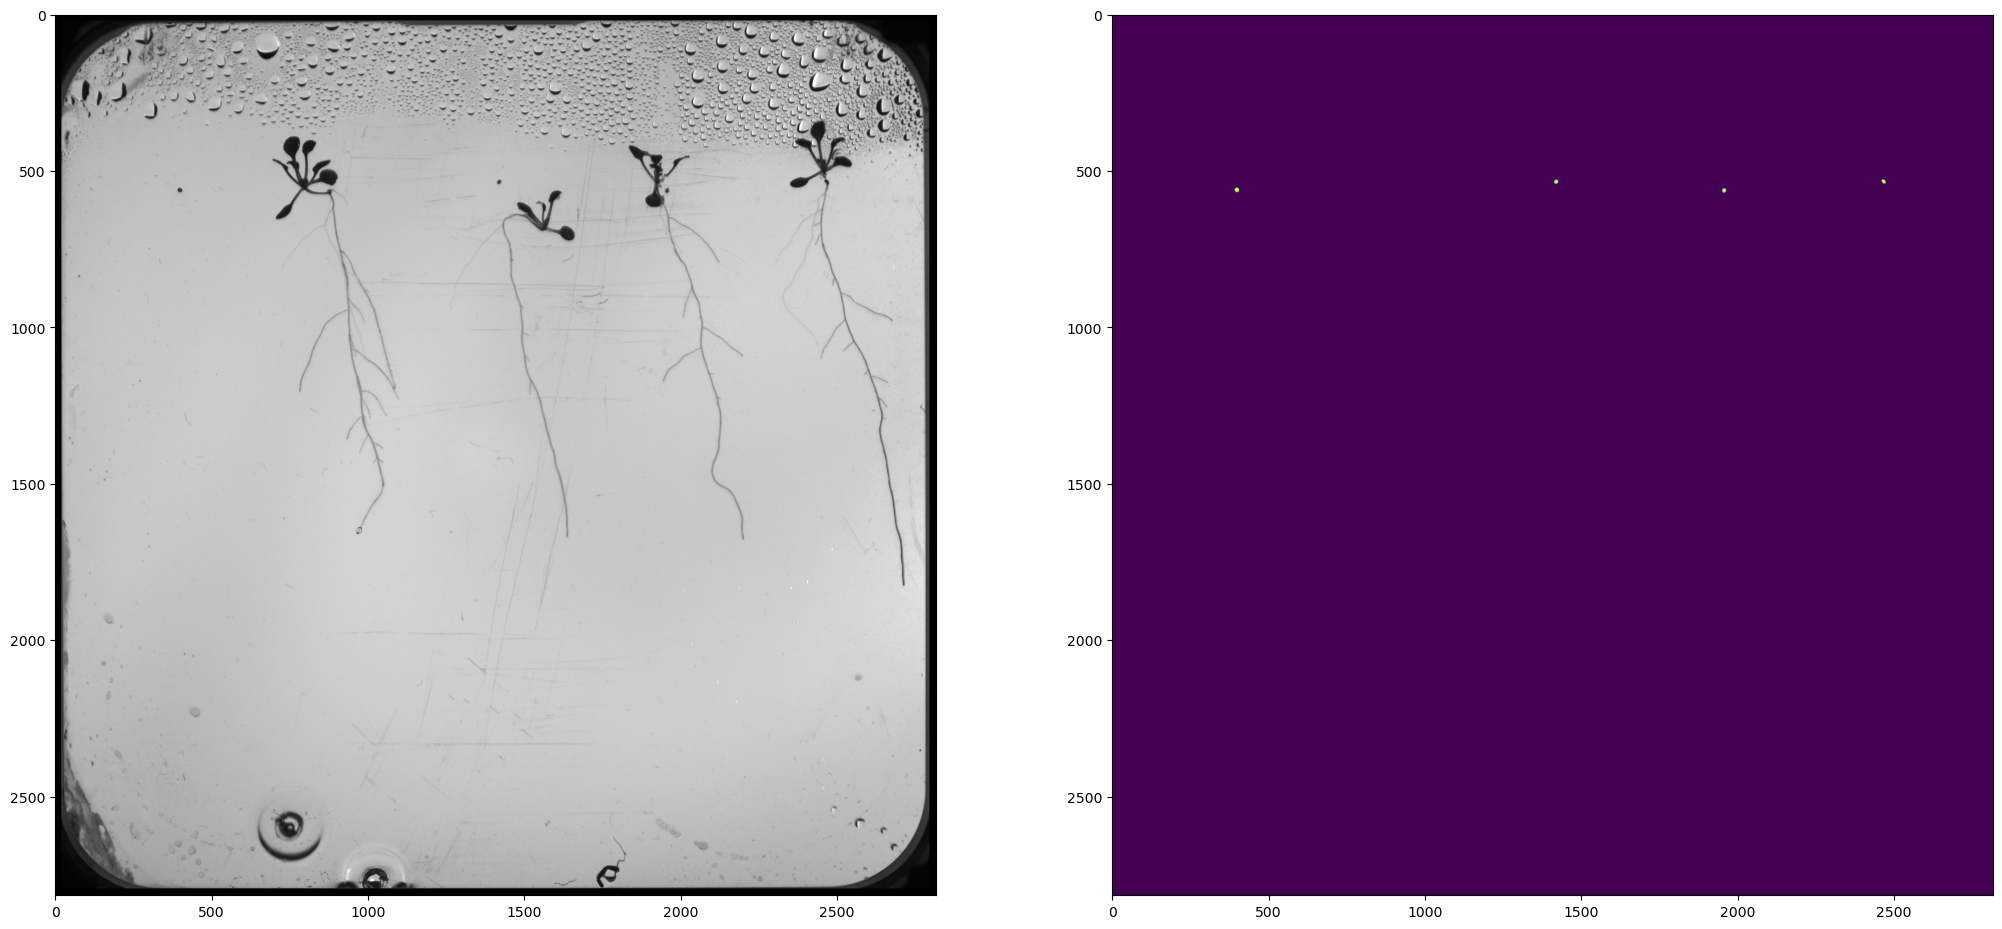

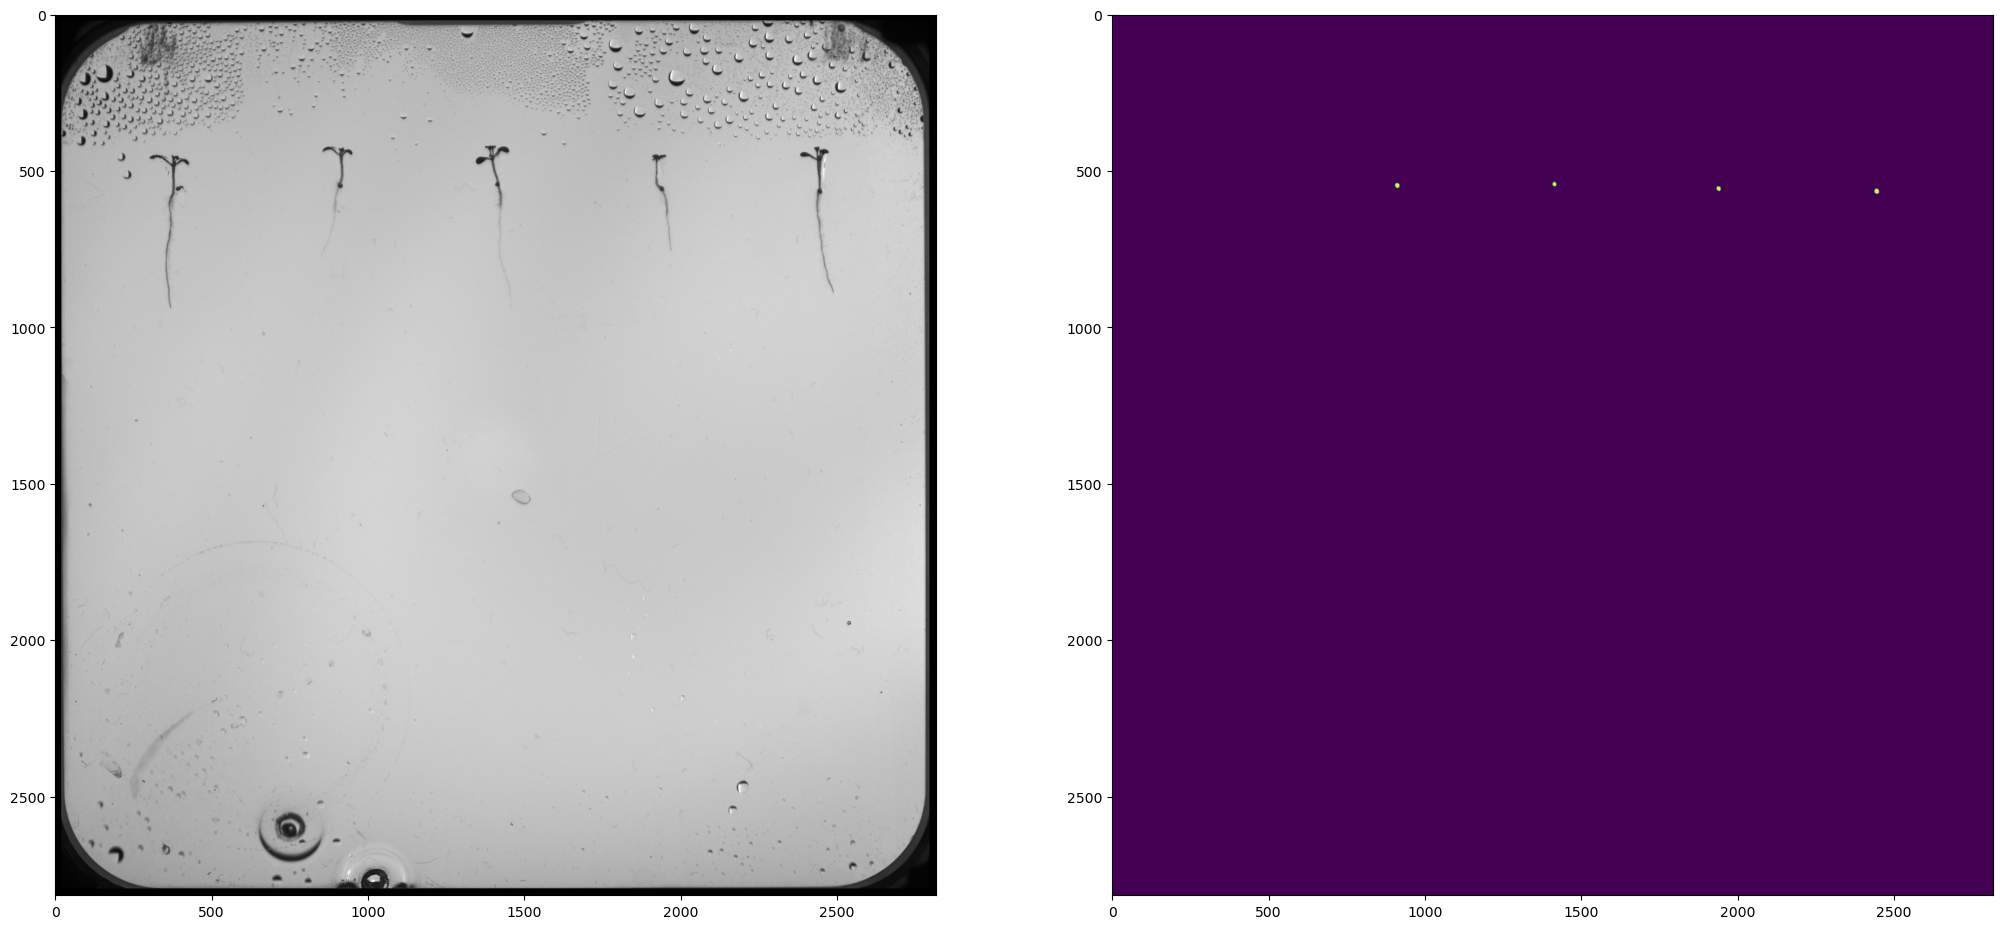

In [39]:
performance('seed',seed_model,patch_size, images_list=test_images_list)

## 4. Occluded root Model

### 4.1 Model training

Found 7648 images belonging to 1 classes.
Found 7648 images belonging to 1 classes.
Found 1911 images belonging to 1 classes.
Found 1911 images belonging to 1 classes.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)  

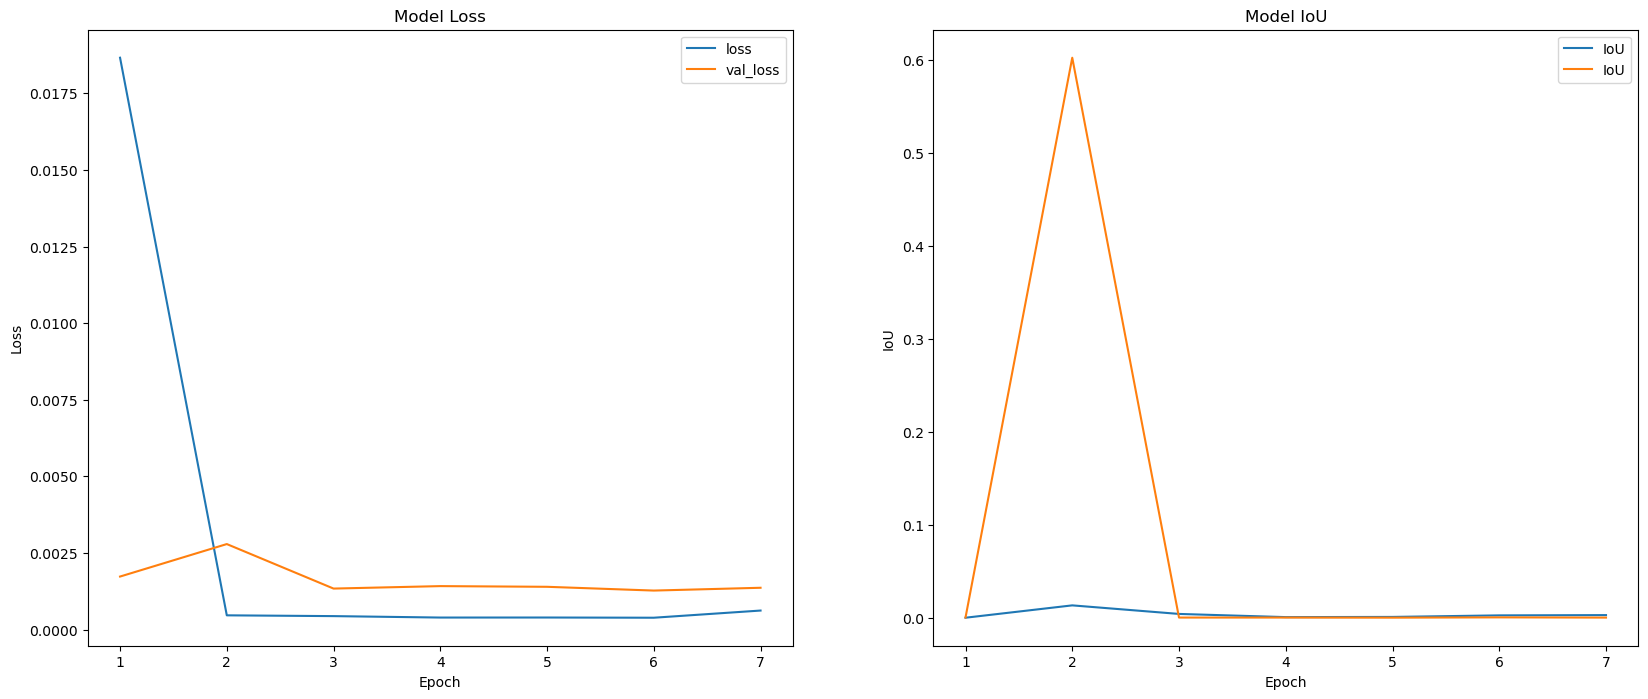

In [22]:
occ_root_model=model_training('occluded_root',patch_size,30)

### 4.2 Performance

Found 2904 images belonging to 1 classes.
Found 2904 images belonging to 1 classes.
IoU for the entire test dataset: 0.98278236


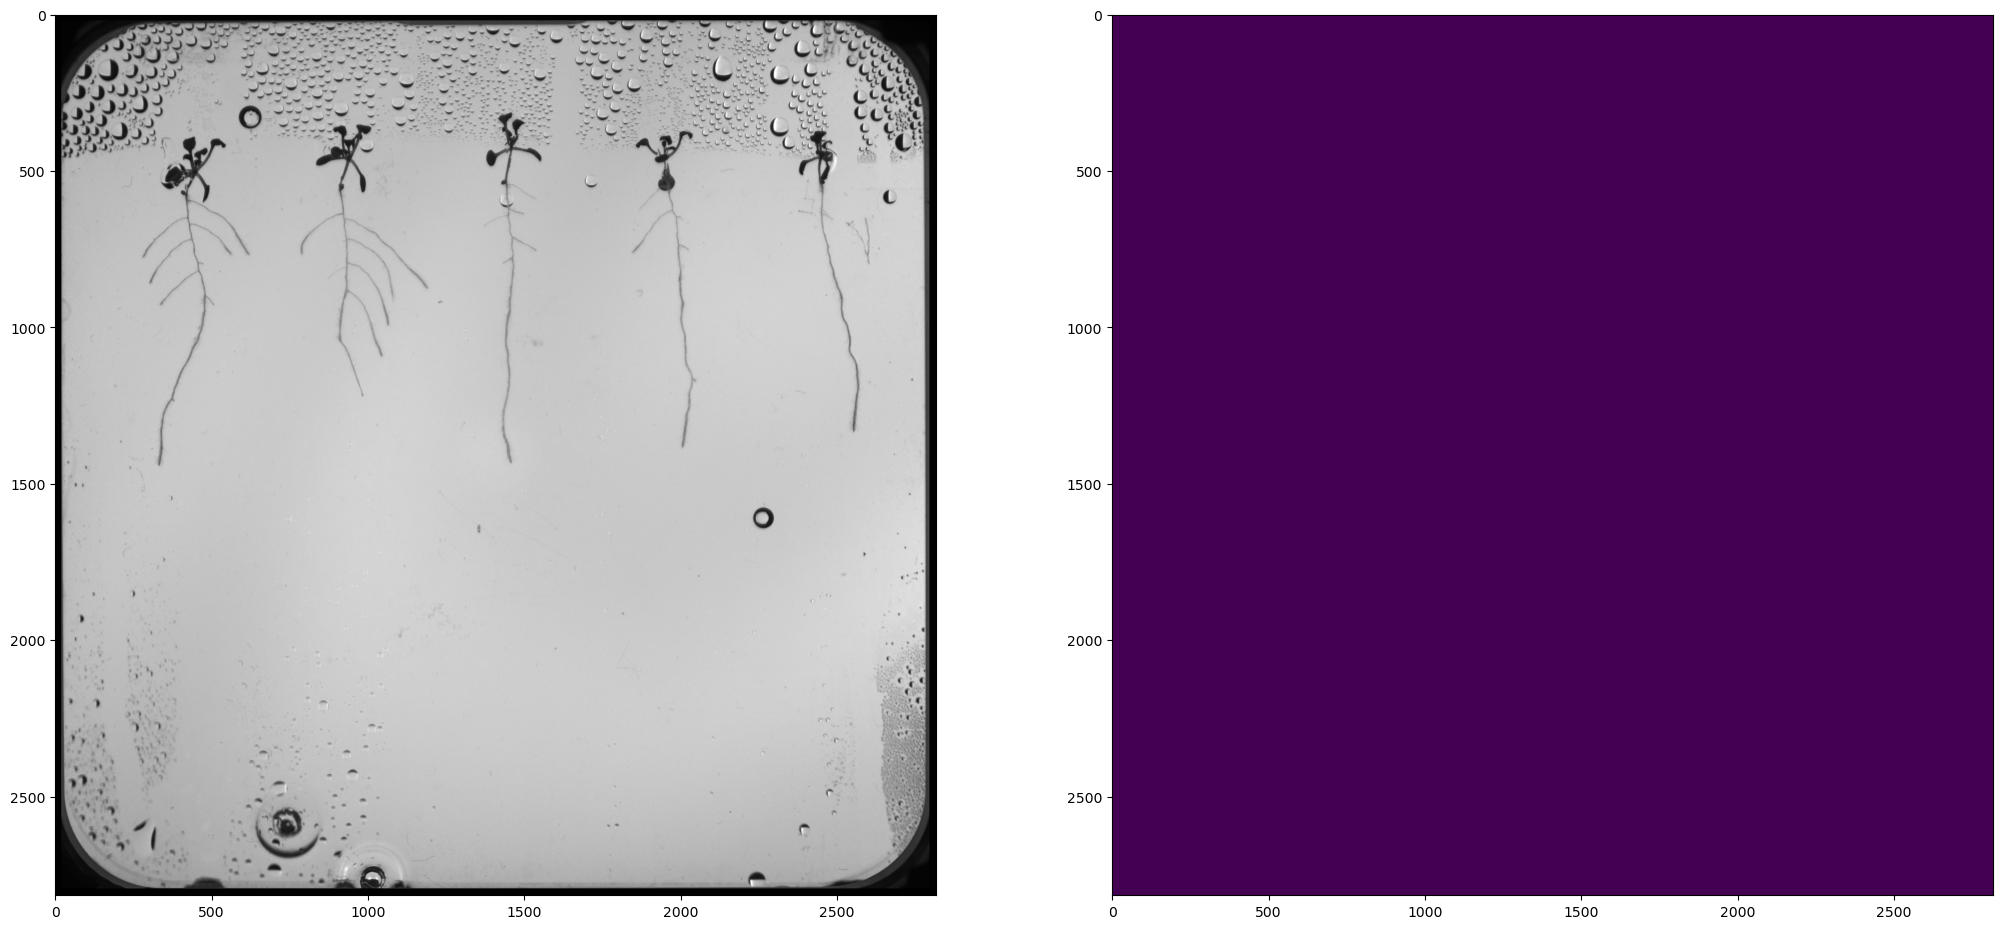

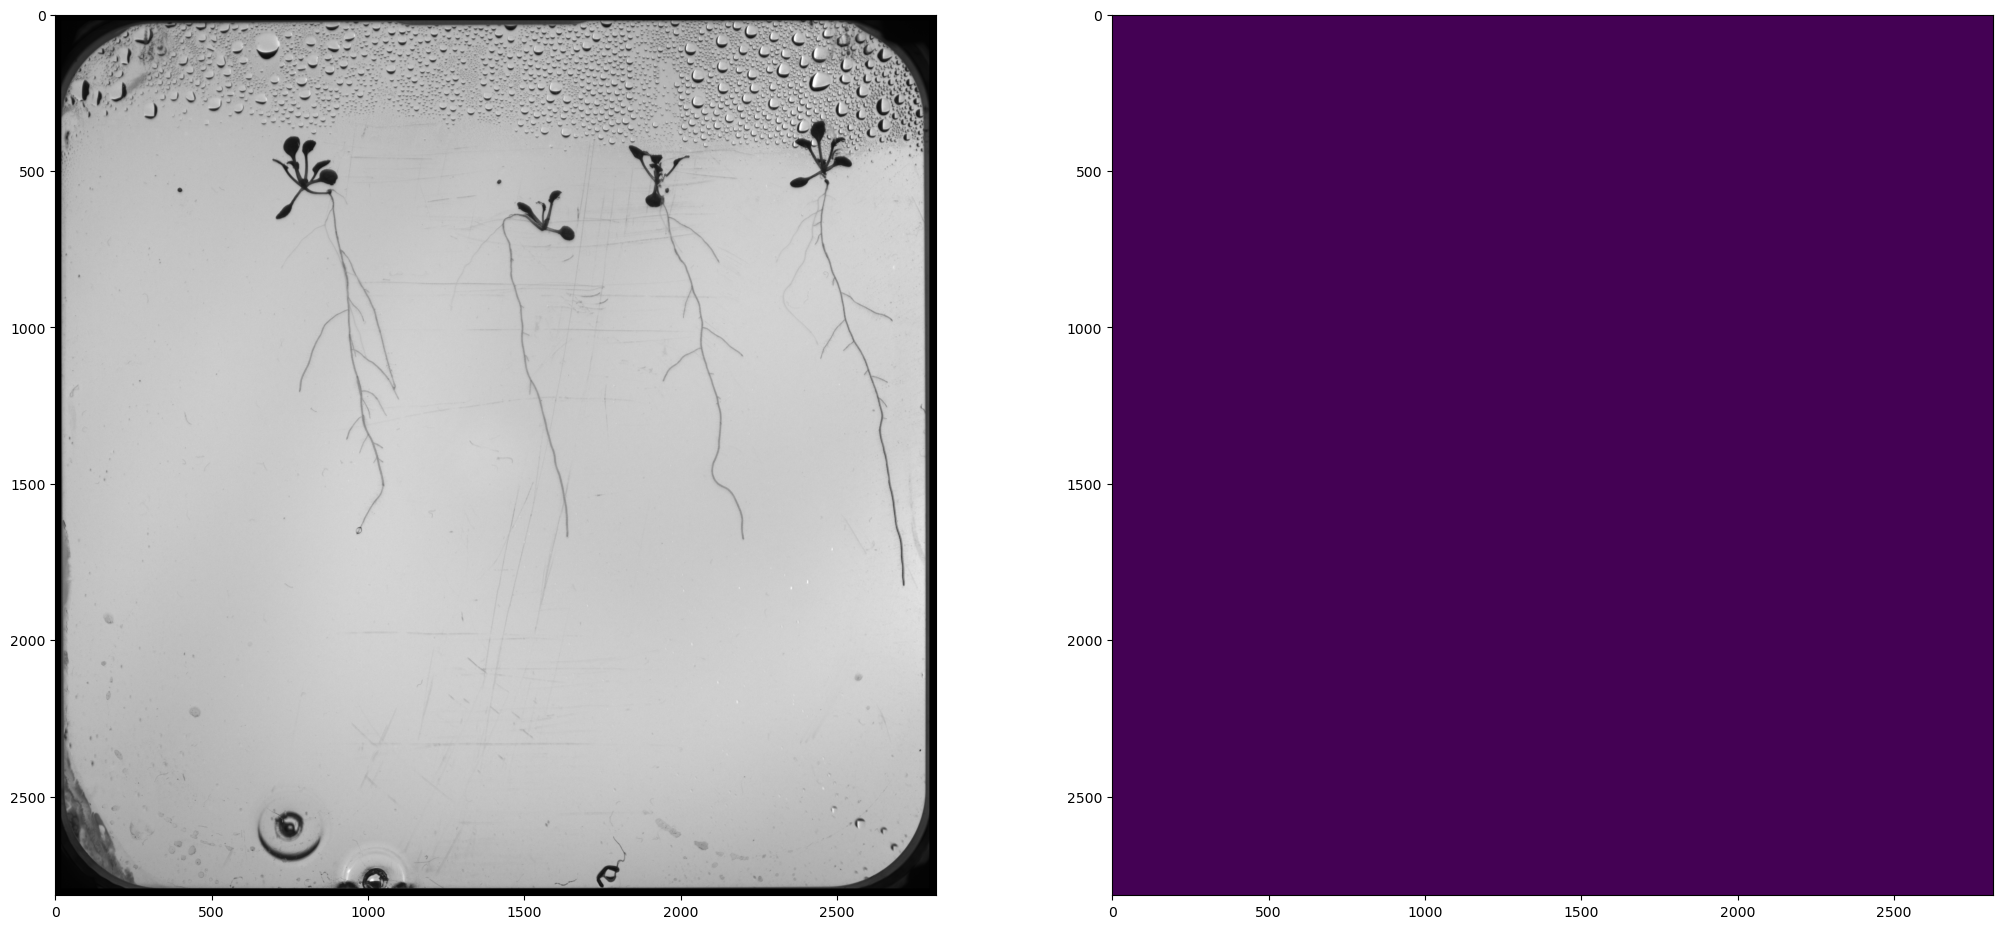

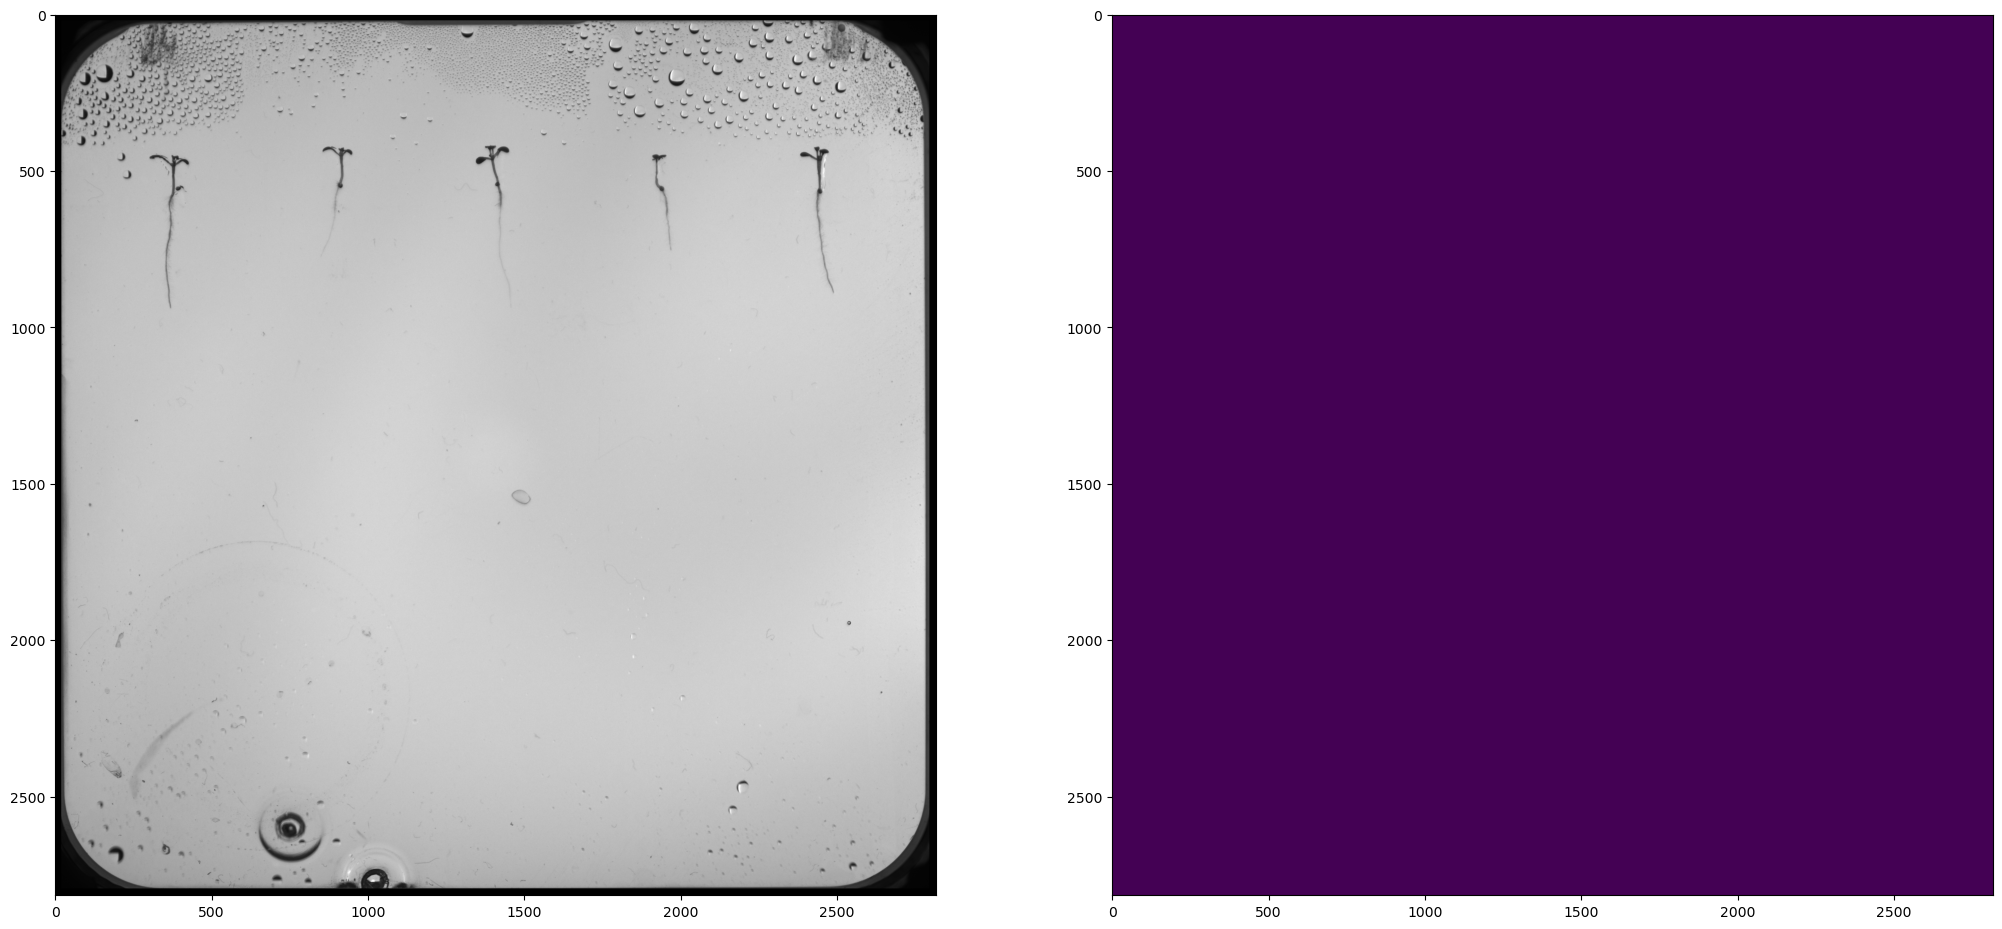

In [35]:
performance('occluded_root',occ_root_model,patch_size, images_list=test_images_list)